# Finding the ground truth about Michael Olma Dataset.
We will present here, the data used for the training set and how many of the parameters are tunned.


## Plan général

* <a href="#PCNA">Analysing Michael Olma data set with the PCNA fluorescent markers</a>
    * <a href="#extraction">Getting the data and naive classification</a>
        * <a href="#firstpeak">First peaks at the data set</a>
        * <a href="#RFClassif">Random Forest Classifier</a>
        * <a href="#Results"> Results of the random forest classifier</a>
        * <a href="#Conclusion"> Conclusion of the random forest and next work</a>
    * <a href="#Hidden markov model">Hidden markov models</a>
        * <a href="#R"> working under R </a>
        * <a href="#Tunning"> Tunning thanks to baumWelch</a>
        * <a href="#Results2"> Results</a>

    * <a href="#ResultsCycles">Results on the cycle lengths</a>
        * <a href="#SmallModif"> Stopping "rotating" trajectories </a>
        * <a href="#GT"> Ground Truth</a>

In [1]:
### All the packages we need:
%matplotlib inline

from Reader import Reader
from Randomforest import RandomForest_Autotunner,plot_matrix,Measure,check_rotate
from Traj_creator import Traj_data

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os.path
import cPickle as pkl


## <a name="PCNA"></a>Analysing Michael Olma data set with the PCNA fluorescent marker

### <a name="extraction"></a>Getting the data and naive classification


In [2]:
num_str="0015" ## Well name
if os.path.isfile("PCNA_data.csv"):
    print "The file existed so I loaded it."
    PCNA=Traj_data(file_name="PCNA_data.csv")
else:
    
    PCNA=Traj_data()  

    PCNA.extracting(num_str,"both_channels_0015.hdf5",'secondary') 
    ## Extracting the hdf5 file for the secondary channel (PCNA)

    PCNA.Add_traj(normalize=False)## ,num_traj=10) ## (you can reduce the number of traj)
    ## Adding Alice's work on tracking to have trajectories

    file_loc="0015_PCNA.xml"

    PCNA.label_finder(file_loc) 
    ## Finding associated labels by minimizing distance by click and distance of cell

    PCNA.renaming_and_merge()  
    ## renaming the labels to have G1=="1", S=="S", G2=="2" and M=="M" 
    #This procedure may take a long time.
    PCNA.to_csv('PCNA_data.csv',index=False,header=True)

The file existed so I loaded it.
Traj_data built
Reader constructed
Updated member Group_of_traj


/home/naylor/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:3006: DtypeWarning: Columns (245) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


### <a name="firstpeak"></a>First peaks at the data set


In [3]:
print "The training set has %d instances and %d features"%PCNA.train.shape
print "The training set has only %d charateristic features out of %d"%(len(PCNA.names),PCNA.train.shape[1])

_rand_index_train=(random.sample(PCNA.train.index,5))
_rand_col  = random.sample(PCNA.names,5)
PCNA.train.ix[_rand_index_train,_rand_col]

The training set has 1273 instances and 246 features
The training set has only 239 charateristic features out of 246


,h4_2CON,dist_min,h8_2ASM,ls1_TAREA_sample_mean,h4_2SAV
16102,79.734024,7.071068,0.018768,10.937392,37.376511
6943,59.567527,6.082763,0.082488,10.545721,38.121396
23049,60.846423,10.198039,0.030653,9.919727,35.301651
6952,35.505479,8.944272,0.013996,10.591346,39.221918
3031,43.349173,9.055385,0.031257,10.344508,38.421723


In [4]:
info_col=[num_str+"_id_frame",num_str+"_id_object",num_str+"_line_id",num_str+"_pos_x",num_str+"_pos_y","traj","Type"]
PCNA.train.ix[_rand_index_train,info_col]

,0015_id_frame,0015_id_object,0015_line_id,0015_pos_x,0015_pos_y,traj,Type
16102,168,46,16102,166,406,NaN,1
6943,83,86,6943,513,799,NaN,1
23049,224,87,23049,1160,597,18,2
6952,83,95,6952,56,903,NaN,2
3031,39,57,3031,1179,637,NaN,2


### <a name="RFClassif"></a>Random Forest Classifier

We are going to first implement a random forest classifier to predict, given the features with the PCNA fluorescent marker, 4 states of the cells:
* __G1__ : For the first gap. (roughly 12 hours long for an average human cell)
* __S__ : When the DNA duplicates. (6 hours long)
* __G2__ : For the second gap. (4 hours long)
* __M__ : When the cell splits. (1 to 2 hours long)

We tune the model by cross validation on the number of trees.

Processing time: 114.566536 in sec
training dataset: 

We now have a classifier with n=290, with an expected accuracy of 0.863 



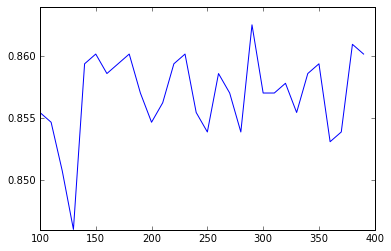

In [5]:
if PCNA.Var_missing[0] in PCNA.train.columns:
    PCNA.missing_features_train()
if PCNA.Var_missing[0] in PCNA.data.columns:
    PCNA.missing_features_data()
values=[100 + i*10 for i in range(30)]
model=RandomForest_Autotunner(values)

model.tunning(PCNA.train[PCNA.names],PCNA.train["Type"],3,plot=True,fit_new_model=True)
print "training dataset: \n"
PCNA.train["Type"].value_counts()

i_=np.argmax(model.MSE)
n_tree=values[i_]
print "We now have a classifier with n=%d, with an expected accuracy of %5.3f \n" %(n_tree,max(model.MSE))

### <a name="Results"></a>Results of the random forest classifier

We expose here the classification results such as the confusion matrix and the normalized confusion matrix.

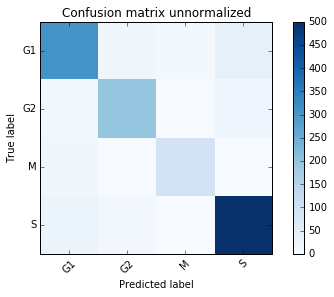

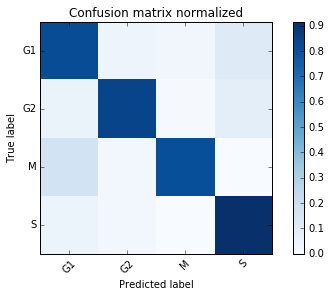

In [6]:
plot_matrix(model.cm,title="Confusion matrix unnormalized")
plt.show()
model.cm_normalized = model.cm.astype('float') / model.cm.sum(axis=1)[:, np.newaxis]
plot_matrix(model.cm_normalized,title="Confusion matrix normalized")
plt.show()

### <a name="Conclusion"></a>Conclusion of the random forest and next work

We have now trained our 1st classifier random forest and have achieved a very reasonable accuracy. With about 86% accurracy and with most classes beeing identifiable.

We have also no missing data if we think about trajectories. We can take into account time dependencies and hope to correct some of the missclassification. The two next blocks show some descriptive statistics about the prediction of the first classification.

In [7]:
index_no_missing=PCNA.data[PCNA.names].dropna(axis=0, how='any').index
PCNA.data.ix[index_no_missing,"Classif_1"]=model.predict(PCNA.data.ix[index_no_missing,PCNA.names])
PCNA.update()
print "Frequency of predicted values: \n"
print PCNA.data["Classif_1"].value_counts()
print "\n We were however not able to predict %d instances because of missing values" % (PCNA.data.shape[0]-len(index_no_missing))

Updated member Group_of_traj
Frequency of predicted values: 

1    34625
S    25506
2    12123
M     6431
Name: Classif_1, dtype: int64

 We were however not able to predict 3 instances because of missing values


This seems reasonable. Will we have to take this into account for the trajectories? Will there be missing data once we look at trajectories (which is a subset of the original data?

In [8]:
temp_X= PCNA.data[pd.notnull(PCNA.data["traj"])]["Classif_1"]

print "Frequency within trajectories: \n"
print temp_X.value_counts()

print "\n We were however not able to predict %d instances because of missing values" % (sum(pd.isnull(temp_X)))

Frequency within trajectories: 

1    14745
S     9716
2     3988
M     1365
Name: Classif_1, dtype: int64

 We were however not able to predict 0 instances because of missing values


## <a name="Hidden markov model"></a>Hidden markov models

We are going to put in place a error correcting model based on time dependencies thanks to hidden markov process. The hidden state will be the true state of the cell, these state follow a markov model with strong beliefs. These beliefs are based on biological processes. 

### <a name="R"></a>Working with R

Because the hidden markov model under python is a huge let down, not much documentation on how input are meant to be realised, I prefered to use R packages. Here we "push" the data we need for the HMM (such as id, traj and the first classification) and also the confusion matrix. 


In [9]:
%load_ext rpy2.ipython
##We reorganise the confusion matrix and push the data...
PCNA.data=PCNA.data.sort_values(['traj', num_str+"_id_frame"], ascending=[1, 1])
X=np.array([model.cm[0],model.cm[3],model.cm[1],model.cm[2]])
X=X.T
X=np.array([X[0],X[3],X[1],X[2]])
X=X.T
print X
X = X.astype('float') / X.sum(axis=1)[:, np.newaxis]

data=PCNA.data.ix[pd.notnull(PCNA.data["traj"]),["traj","Classif_1"]]
data.ix[data.Classif_1=='2',"Classif_1"]="3"
data.ix[data.Classif_1=='M',"Classif_1"]="4"
data.ix[data.Classif_1=='S',"Classif_1"]="2"

%Rpush X data

[[308  42  17  11]
 [ 30 500  15   1]
 [ 14  21 199   2]
 [ 19   0   3  91]]


### <a name="Tunning"></a> Tunning thanks to baumWelch

To tune our model, i.e. finding the correct transition matrix, we used the baumWelch algorithm under R. Because this algorithm is EM based we should initiate it several times to ensure that we are not blocked local maximas. However, we do not worry about this problem as we have a very strong prior and first guess about the transition matrix. 

For each trajectory, we tune a transition matrix, we then store this transition matrix. To asses the robustness of the transition matrix given we look at his mean and the variance of the transition matrix. We did the same with the emission probability matrix even if we wish to use the confusion matrix given by the first classifier that gives our model a very nice interpretation.

In [10]:
%%R 
obs_number=0
print(paste("To assess briefly what is happening, we printed a sequence of observation, sequence number:",toString(obs_number) ))
library(HMM)
trans=list()  #List of outputs
emi=list()    

emission_matrix=X
transition_prior=t(matrix(c(  .7  , .28 , .01 , .01
                            , .01 , .7  , .28 , .01
                            , .01 , .01 , .7  , .28 
                            , .28 , .01 , .01 , .7 ),4)) 

startProbs=c(0.7, 0.0, 0.0, 0.3)

hmm = initHMM(c("1","2","3","4"),c("1","2","3","4"),
              transProbs=transition_prior,
              emissionProbs=emission_matrix
              ,startProbs=startProbs)


n_traj=max(data$traj)
j=1
for (i in 0:(n_traj-1)){
    obs=data[data$traj==i,"Classif_1"]
    if (i==obs_number){print(obs)}
    hmm = initHMM(c("1","2","3","4"),c("1","2","3","4"),
                  startProbs=startProbs,
                  emissionProbs=emission_matrix,
                  transProbs=transition_prior)
    bw=try(baumWelch(hmm,observation=obs,10),silent = TRUE)
    if (!(inherits(bw, "try-error"))){
      trans[[j]]=bw$hmm$transProbs
      emi[[j]]=bw$hmm$emissionProbs
      j=j+1  
    }
}



[1] "To assess briefly what is happening, we printed a sequence of observation, sequence number: 0"
  [1] 4 4 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [38] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 2 1 1 1 1 2 1 2 2 2 2 2
 [75] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[112] 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
[149] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 1 4 4 4 4
Levels: 1 2 3 4


In [11]:
%%R

mean_t=matrix(0,ncol=4,nrow=4)
mean_e=matrix(0,ncol=4,nrow=4)
for (i in 1:length(trans)){
  mean_t=mean_t+trans[[i]]
  mean_e=mean_e+emi[[i]]
}
mean_t=mean_t/length(trans)
mean_e=mean_e/length(trans)

var_t=matrix(0,ncol=4,nrow=4)
var_e=matrix(0,ncol=4,nrow=4)

for (i in 1:length(trans)){
  var_t=var_t+(trans[[i]]-mean_t)*(trans[[i]]-mean_t)
  var_e=var_e+(emi[[i]]-mean_e)*(emi[[i]]-mean_e)
}
var_t=var_t/length(trans)
var_e=var_e/length(trans)

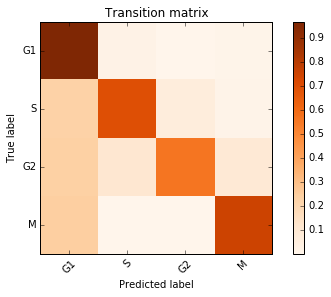

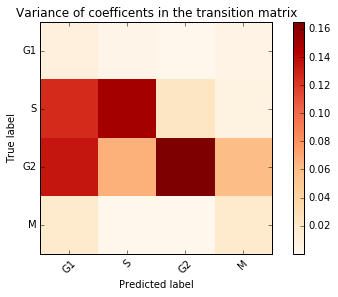

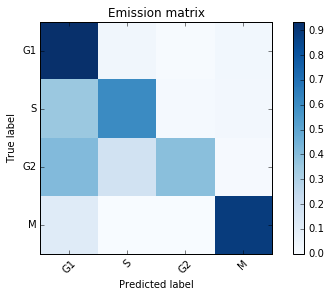

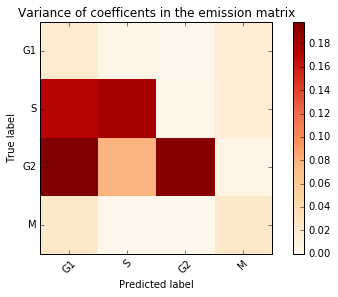

In [12]:
%Rpull mean_t mean_e var_t var_e
plot_matrix(mean_t,title="Transition matrix",names=["G1","S","G2","M"],cmap=plt.cm.Oranges)
plt.show()
plot_matrix(var_t,title="Variance of coefficents in the transition matrix",names=["G1","S","G2","M"],cmap=plt.cm.OrRd)
plt.show()
plot_matrix(mean_e,title="Emission matrix",names=["G1","S","G2","M"])
plt.show()
plot_matrix(var_e,title="Variance of coefficents in the emission matrix",names=["G1","S","G2","M"],cmap=plt.cm.OrRd)
plt.show()

We modify the transition matrix to take into account our strong beliefs about the bioloigical processes

In [13]:
%%R 
ligne1=mean_t[1,1]+mean_t[1,2]
ligne2=mean_t[2,2]+mean_t[2,3]
ligne3=mean_t[3,3]+mean_t[3,4]
ligne4=mean_t[4,1]+mean_t[4,4]

transProbs=t(matrix(c(mean_t[1,1]/ligne1  , mean_t[1,2]/ligne1    ,0                 , 0
                      , 0                 , mean_t[2,2]/ligne2    ,mean_t[2,3]/ligne2, 0
                      , 0                 , 0                     ,mean_t[3,3]/ligne3, mean_t[3,4]/ligne3
                      ,mean_t[4,1]/ligne4 , 0                     ,0                 , mean_t[4,4]/ligne4),4))

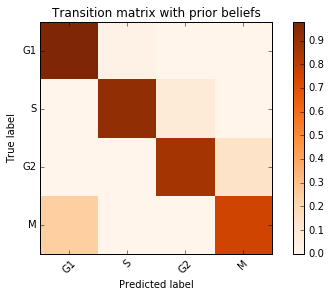

In [14]:
%Rpull transProbs
plot_matrix(transProbs,title="Transition matrix with prior beliefs",names=["G1","S","G2","M"],cmap=plt.cm.Oranges)

In [15]:
%%R 
startProbs=c(.7,0,0,.3)
obs_number=0
hmm = initHMM(c("1","2","3","4"),c("1","2","3","4"),
              transProbs=transProbs,
              emissionProbs=emission_matrix ##We still keep the confusion matrix of the first classification
              ,startProbs=startProbs)


for (i in 0:(n_traj-1)){
  obs=data[data$traj==i,"Classif_1"]
  new_obs=as.integer(viterbi(hmm,observation=obs))
  data[data$traj==i,"HMM"]=new_obs
  if (i==obs_number){
      print(paste("To assess briefly what is happening, we printed a sequence of observation and it's correction, sequence number:",toString(obs_number) ))
      print("Classif_1:")
      print(obs)
      print("Corrected:")
      print(new_obs)
  }
}


[1] "To assess briefly what is happening, we printed a sequence of observation and it's correction, sequence number: 0"
[1] "Classif_1:"
  [1] 4 4 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [38] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 2 1 1 1 1 2 1 2 2 2 2 2
 [75] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[112] 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
[149] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 1 4 4 4 4
Levels: 1 2 3 4
[1] "Corrected:"
  [1] 4 4 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [38] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2
 [75] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[112] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
[149] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4


We bring the data back to python and quickly assess if everything is still coherent.

In [16]:
%Rpull data

data.ix[data.HMM==1,"HMM"]="1"
data.ix[data.HMM==2,"HMM"]="S"
data.ix[data.HMM==3,"HMM"]="2"
data.ix[data.HMM==4,"HMM"]="M"
to_join=pd.Series(data["HMM"])
to_join.index=[int(el) for el in to_join.index]

PCNA.data=PCNA.data.join(to_join)
PCNA.update()

PCNA.train.ix[_rand_index_train,["traj","Type","Classif_1","HMM"]]

Updated member Group_of_traj


,traj,Type,Classif_1,HMM
16102,NaN,1,1,NaN
6943,NaN,1,1,NaN
23049,18,2,2,2
6952,NaN,2,2,NaN
3031,NaN,2,2,NaN


### <a name="Results2"></a> Results


S    217
1    199
2     56
M     36
Name: Type, dtype: int64
We reach an accuracy of 0.969 



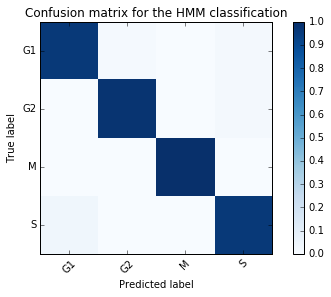

In [17]:
from sklearn.metrics import confusion_matrix

temp_X=PCNA.train.ix[pd.notnull(PCNA.train["HMM"]),["HMM","Type"]]
print temp_X["Type"].value_counts()
cm=confusion_matrix(temp_X.Type,temp_X.HMM)

print "We reach an accuracy of %5.3f \n" %(float(cm.trace())/cm.sum())

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plot_matrix(cm_normalized,title="Confusion matrix for the HMM classification")

### <a name="ResultsCycles"></a> Results on the cycle lengths

In order to get some ground truth about the data, we now will use the prediction made along a trajectory and save the lengths of the values.

In [18]:
i=0
obs_number=9
G1=[]
S=[]
G2=[]
CC=[]
print "To quickly asses we print the trajectory and his corrected trajectory, for sequence number:" + str(obs_number)
for el in PCNA.Group_of_traj:
    new_obs=el[1]["HMM"]
    if i==obs_number:
        test=np.array(el[1]["Classif_1"])
        test_hmm=np.array(el[1]["HMM"])
        print "Classif_1: \n"
        print test
        print "Corrected: \n"
        print test_hmm
    i+=1
    if not check_rotate(new_obs):
        G1.append(Measure(new_obs,'1',_last=True))
        S.append(Measure(new_obs,'S',_last=True,_first=True))
        G2.append(Measure(new_obs,'2',_first=True))
        CC.append(Measure(new_obs,'M'))
    elif not check_rotate(new_obs[:-1]):
        G1.append(Measure(new_obs[:-1],'1',_last=True))
        S.append(Measure(new_obs[:-1],'S',_last=True,_first=True))
        G2.append(Measure(new_obs[:-1],'2',_first=True))
        CC.append(Measure(new_obs[:-1],'M'))
    elif not check_rotate(new_obs[:-2]):
        G1.append(Measure(new_obs[:-2],'1',_last=True))
        S.append(Measure(new_obs[:-2],'S',_last=True,_first=True))
        G2.append(Measure(new_obs[:-2],'2',_first=True))
        CC.append(Measure(new_obs[:-2],'M'))
    else:
        G1.append(-1)
        S.append(-1)
        G2.append(-1)
        CC.append(-1)


To quickly asses we print the trajectory and his corrected trajectory, for sequence number:9
Classif_1: 

['M' 'M' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1'
 '1' '1' 'S' '1' '1' 'S' '1' 'S' '2' '2' 'S' '1' 'S' '1' '2' 'S' 'S' 'S'
 '1' '1' '1' '1' '1' 'S' '1' '1' '1' '1' '1' '1' '2' 'S' '2' '2' '2' 'S'
 '2' '2' '2' '2' '2' '2' '2' 'S' '2' '2' 'S' '2' '2' '2' 'S' '2' 'S' '2'
 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' '2' 'S'
 'S' 'S' 'S' '2' 'S' 'S' 'S' 'S' 'S' 'S' '2' 'S' 'S' 'S' 'S' 'S' 'S' '2'
 'S' 'S' 'S' 'S' 'S' '2' '2' 'S' '2' 'S' '2' 'S' 'S' 'S' 'S' 'S' 'S' 'S'
 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' '2' '2' '2' 'S' '2' '2' '2' '2'
 '2' '2' '2' '2' '2' '2' '2' '2' 'S' '2' 'S' 'S' '2' '2' '2' '2' 'S' '2'
 '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' 'S' '2' '1' 'M' 'M' 'M']
Corrected: 

['M' 'M' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1'
 '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1'
 '1' '1' '1'

This first classification suffers from a poor prediction of M in the set. It may be interesting to add a first classifier for Mitosis, or to change the Markov process to take into account another variable to stop rotations.

NB: This first idea may seem incorrect, we might need to strenghen the hidden markov model to not allow return steps. By creating a 5 step HMM, M0 (begining) and M1 (ending).

In [19]:
from numpy import mean,std
ratio=5.9/60
G1_p=[el*ratio for el in G1 if el>-1]
S_p= [el*ratio for el in S  if el>-1]
G2_p=[el*ratio for el in G2 if el>-1]
CC_p=[el*ratio for el in CC if el>-1] 
res_1 = {'mean' : pd.Series([mean(G1_p), mean(S_p), mean(G2_p),mean(CC_p)], index=['G1', 'S', 'G2','CellCycle']),
'Standard deviation' : pd.Series([std(G1_p),std(S_p),std(G2_p),std(CC_p)], index=['G1', 'S', 'G2','CellCycle']),
'Accepted trajectories': pd.Series([len(G1_p),len(S_p),len(G2_p),len(CC_p)], index=['G1', 'S', 'G2','CellCycle'])
      }
pd.DataFrame(res_1)

,Accepted trajectories,Standard deviation,mean
G1,118,2.472911,7.062500
S,85,1.715657,6.289863
G2,85,1.010876,3.354902
CellCycle,85,2.136217,16.663451


We do not accept enough trajectories out of the 236 possible trajectories. To help, we will change the hidden markov model so that we can't rotate (cf traj number 9 above).

### <a name="SmallModif"></a> Stopping "rotating" trajectories

We start again from the first classification, but first, we will rename the M on the "first-half" to be __B__ and the M's on the "second-half" to be __E__.

In [20]:
for i in range(len(PCNA.trajectories)):
    new_obs=np.array(PCNA.data.ix[PCNA.data["traj"]==i,"Classif_1"])
    n_obs=len(new_obs)
    for j in range(n_obs/2):
        if new_obs[j]=='M':
            new_obs[j]='B'  #Beginning
    PCNA.data.ix[PCNA.data["traj"]==i,"Classif_2"]=new_obs
PCNA.data.ix[PCNA.data["Classif_2"]=='M',"Classif_2"]='E' #Ending

##PCNA.data.ix[PCNA.data["traj"]==0,["Classif_2","Classif_1"]]
np.set_printoptions(precision = 4, suppress = True)
X5=np.zeros(shape=(5,5))
X5[1:5,1:5]=X
X5[0,1:4]=X[3,0:3]
M_2=X[3,3]

X5[0,0]=M_2
X5[4,4]=M_2

X5[0:3,3]=X[0:3,3]/2
X5[1:4,0]=X[0:3,3]

print "New emission matrix: \n"
print X5

PCNA.data=PCNA.data.sort_values(['traj', num_str+"_id_frame"], ascending=[1, 1])

data=PCNA.data.ix[pd.notnull(PCNA.data["traj"]),["traj","Classif_2"]]


data.ix[data.Classif_2=='2',"Classif_2"]="4"
data.ix[data.Classif_2=='1',"Classif_2"]="2"
data.ix[data.Classif_2=='B',"Classif_2"]="1"
data.ix[data.Classif_2=='E',"Classif_2"]="5"
data.ix[data.Classif_2=='S',"Classif_2"]="3"

%Rpush X5
%Rpush data 

New emission matrix: 

[[ 0.8053  0.1681  0.      0.0146  0.    ]
 [ 0.0291  0.8148  0.1111  0.0009  0.0291]
 [ 0.0018  0.0549  0.9158  0.0042  0.0018]
 [ 0.0085  0.0593  0.089   0.8432  0.0085]
 [ 0.      0.1681  0.      0.0265  0.8053]]


In [21]:
%%R 
obs_number=0
print(paste("To assess briefly what is happening, we printed a sequence of observation, sequence number:",toString(obs_number) ))

library(HMM)
trans=list()  #List of outputs
emi=list()    

emission_matrix=X
transition_prior=t(matrix(c(  .7  , .27 , .01 , .01 , .01
                            , .01 , .7  , .27 , .01 , .01
                            , .01 , .01 , .7  , .27 , .01
                            , .01 , .01 , .01 , .7  , .27
                            , .01 , .01 , .01 , .01  , 0.96 ),5)) 

startProbs=c(0.3, 0.7, 0.0, 0.0, 0.0)

hmm = initHMM(c("1","2","3","4","5"),c("1","2","3","4","5"),
              transProbs=transition_prior,
              emissionProbs=X5
              ,startProbs=startProbs)


n_traj=max(data$traj)
j=1
for (i in 0:(n_traj-1)){
    obs=data[data$traj==i,"Classif_2"]
    if (i==obs_number){print(obs)}
    hmm = initHMM(c("1","2","3","4","5"),c("1","2","3","4","5"),
                  startProbs=startProbs,
                  emissionProbs=X5,
                  transProbs=transition_prior)
    bw=try(baumWelch(hmm,observation=obs,10),silent = TRUE)
    if (!(inherits(bw, "try-error"))){
      trans[[j]]=bw$hmm$transProbs
      emi[[j]]=bw$hmm$emissionProbs
      j=j+1  
    }
}

mean_t=matrix(0,ncol=5,nrow=5)
mean_e=matrix(0,ncol=5,nrow=5)
for (i in 1:length(trans)){
  mean_t=mean_t+trans[[i]]
  mean_e=mean_e+emi[[i]]
}
mean_t=mean_t/length(trans)
mean_e=mean_e/length(trans)

var_t=matrix(0,ncol=5,nrow=5)
var_e=matrix(0,ncol=5,nrow=5)

for (i in 1:length(trans)){
  var_t=var_t+(trans[[i]]-mean_t)*(trans[[i]]-mean_t)
  var_e=var_e+(emi[[i]]-mean_e)*(emi[[i]]-mean_e)
}
var_t=var_t/length(trans)
var_e=var_e/length(trans)

[1] "To assess briefly what is happening, we printed a sequence of observation, sequence number: 0"
  [1] 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [38] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 3 2 2 2 2 3 2 3 3 3 3 3
 [75] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[112] 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4
[149] 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 2 5 5 5 5
Levels: 1 2 3 4 5


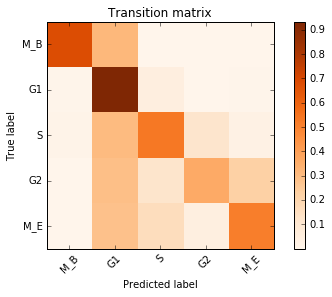

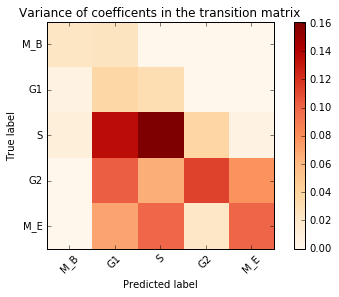

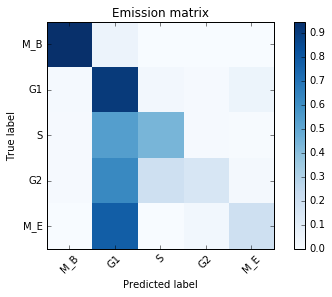

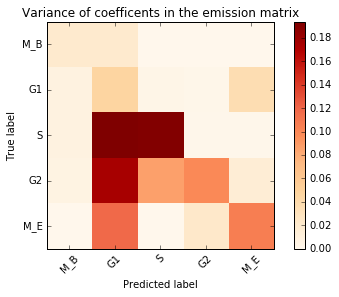

In [22]:
%Rpull mean_t mean_e var_t var_e
plot_matrix(mean_t,title="Transition matrix",names=["M_B","G1","S","G2","M_E"],cmap=plt.cm.Oranges)
plt.show()
plot_matrix(var_t,title="Variance of coefficents in the transition matrix",names=["M_B","G1","S","G2","M_E"],cmap=plt.cm.OrRd)
plt.show()
plot_matrix(mean_e,title="Emission matrix",names=["M_B","G1","S","G2","M_E"])
plt.show()
plot_matrix(var_e,title="Variance of coefficents in the emission matrix",names=["M_B","G1","S","G2","M_E"],cmap=plt.cm.OrRd)
plt.show()

In [23]:
%%R 
obs_number=2

ligne1=mean_t[1,1]+mean_t[1,2]
ligne2=mean_t[2,2]+mean_t[2,3]
ligne3=mean_t[3,3]+mean_t[3,4]
ligne4=mean_t[4,4]+mean_t[4,5]

transProbs=t(matrix(c(mean_t[1,1]/ligne1  , mean_t[1,2]/ligne1    ,0                 , 0                 ,0
                      , 0                 , mean_t[2,2]/ligne2    ,mean_t[2,3]/ligne2, 0                 ,0
                      , 0                 , 0                     ,mean_t[3,3]/ligne3, mean_t[3,4]/ligne3,0
                      , 0                 , 0                     ,0                 , mean_t[4,4]/ligne4,mean_t[4,5]/ligne4
                      , 0                 , 0                     ,0                 , 0                 ,1 ),5))
startProbs=c(0.3, 0.7, 0.0, 0.0, 0.0)

hmm = initHMM(c("1","2","3","4","5"),c("1","2","3","4","5"),
              transProbs=transProbs,
              emissionProbs=X5  ##We still keep the confusion matrix of the first classification
              ,startProbs=startProbs)

print(paste("To assess briefly what is happening, we printed a sequence of observation, sequence number:",toString(obs_number) ))

for (i in 0:(n_traj-1)){
  obs=data[data$traj==i,"Classif_2"]
  new_obs=as.integer(viterbi(hmm,observation=obs))
  data[data$traj==i,"HMM_2"]=new_obs
  if (i==obs_number){
      print(obs)
      print(new_obs)
  }
}


[1] "To assess briefly what is happening, we printed a sequence of observation, sequence number: 2"
  [1] 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [38] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 4 3 3 4 2 2 3 3 3
 [75] 2 2 4 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[112] 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4
[149] 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
[186] 4 4 3 5 5 5 5
Levels: 1 2 3 4 5
  [1] 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [38] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [75] 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[112] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4
[149] 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
[186] 4 4 4 5 5 5 5


In [24]:
## If needed...
##PCNA.data=PCNA.data.drop("HMM_2",axis=1)

In [25]:
%Rpull data

data.ix[data.HMM_2==1,"HMM_2"]="M"
data.ix[data.HMM_2==2,"HMM_2"]="1"
data.ix[data.HMM_2==3,"HMM_2"]="S"
data.ix[data.HMM_2==4,"HMM_2"]="2"
data.ix[data.HMM_2==5,"HMM_2"]="M"
to_join=pd.Series(data["HMM_2"])
to_join.index=[int(el) for el in to_join.index]

PCNA.data=PCNA.data.join(to_join)
PCNA.update()

print PCNA.train.ix[_rand_index_train,["traj","Type","Classif_1","HMM","Classif_2","HMM_2"]]


obs_number=2
i=0
G1_2=[]
S_2=[]
G2_2=[]
CC_2=[]
print "To quickly asses we print the trajectory and his corrected trajectory, for sequence number:" + str(obs_number)
for el in PCNA.Group_of_traj:
    new_obs=el[1]["HMM_2"]
    if i==obs_number:
        test=np.array(el[1]["Classif_2"])
        test_hmm=np.array(el[1]["HMM_2"])
        print "Classif_2: \n"
        print test
        print "\n Corrected_2: \n"
        print test_hmm
    i+=1
    if not check_rotate(new_obs):
        G1_2.append(Measure(new_obs,'1',_last=True))
        S_2.append(Measure(new_obs,'S',_last=True,_first=True))
        G2_2.append(Measure(new_obs,'2',_first=True))
        CC_2.append(Measure(new_obs,'M'))
    elif not check_rotate(new_obs[:-1]):
        G1_2.append(Measure(new_obs[:-1],'1',_last=True))
        S_2.append(Measure(new_obs[:-1],'S',_last=True,_first=True))
        G2_2.append(Measure(new_obs[:-1],'2',_first=True))
        CC_2.append(Measure(new_obs[:-1],'M'))
    elif not check_rotate(new_obs[:-2]):
        G1_2.append(Measure(new_obs[:-2],'1',_last=True))
        S_2.append(Measure(new_obs[:-2],'S',_last=True,_first=True))
        G2_2.append(Measure(new_obs[:-2],'2',_first=True))
        CC_2.append(Measure(new_obs[:-2],'M'))
    else:
        G1_2.append(-1)
        S_2.append(-1)
        G2_2.append(-1)
        CC_2.append(-1)
        
from numpy import mean,std
ratio=5.9/60
G1_p_2=[el*ratio for el in G1_2 if el>-1]
S_p_2= [el*ratio for el in S_2  if el>-1]
G2_p_2=[el*ratio for el in G2_2 if el>-1]
CC_p_2=[el*ratio for el in CC_2 if el>-1] 
res_2 = {'mean' : pd.Series([mean(G1_p_2), mean(S_p_2), mean(G2_p_2),mean(CC_p_2)], index=['G1', 'S', 'G2','CellCycle']),
'Standard deviation' : pd.Series([std(G1_p_2),std(S_p_2),std(G2_p_2),std(CC_p_2)], index=['G1', 'S', 'G2','CellCycle']),
'Accepted trajectories': pd.Series([len(G1_p_2),len(S_p_2),len(G2_p_2),len(CC_p_2)], index=['G1', 'S', 'G2','CellCycle'])
      }

Updated member Group_of_traj
       traj Type Classif_1  HMM Classif_2 HMM_2
16102   NaN    1         1  NaN       NaN   NaN
6943    NaN    1         1  NaN       NaN   NaN
23049    18    2         2    2         2     2
6952    NaN    2         2  NaN       NaN   NaN
3031    NaN    2         2  NaN       NaN   NaN
To quickly asses we print the trajectory and his corrected trajectory, for sequence number:2
Classif_2: 

['B' 'B' 'B' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1'
 '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1'
 '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1'
 '1' '1' '1' '1' '1' '1' '1' '1' '1' 'S' '1' '2' 'S' 'S' '2' '1' '1' 'S'
 'S' 'S' '1' '1' '2' '1' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S'
 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S'
 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' '2' 'S' 'S' 'S' 'S' 'S' 'S'
 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' '

### <a name="GT"></a> Ground truth


In [26]:
print "With only M: \n"
pd.DataFrame(res_1)

With only M: 



,Accepted trajectories,Standard deviation,mean
G1,118,2.472911,7.062500
S,85,1.715657,6.289863
G2,85,1.010876,3.354902
CellCycle,85,2.136217,16.663451


In [27]:
print "With B and E: \n"
pd.DataFrame(res_2)

With B and E: 



,Accepted trajectories,Standard deviation,mean
G1,159,3.790125,7.138134
S,124,2.932716,6.275887
G2,124,1.409364,3.172836
CellCycle,124,4.076787,16.640538
